In [2]:
import numpy as np

class Linear:
    def __init__(self, m, n):
        self.weight = np.random.randn(m, n) * np.sqrt(2 / m)
        self.bias = np.random.randn(n) * 0.01
        
        self.first_moment = np.zeros((m, n))
        self.second_moment = np.zeros((m, n))
        
        self.bias_first_moment = np.zeros(n)
        self.bias_second_moment = np.zeros(n)
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 1e-4
        
        self.step = 0
        
        self.input = None
        
    def forward(self, input):
        self.input = input
        return np.dot(input, self.weight) + self.bias
    
    def backward(self, output_gradient):
        self.step += 1
        
        input_gradient = np.dot(output_gradient, self.weight.T)
        weight_gradient = np.dot(self.input.T, output_gradient)
        bias_gradient = np.sum(output_gradient, axis=0)
        
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * weight_gradient
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * weight_gradient * weight_gradient
        
        self.bias_first_moment = self.beta1 * self.bias_first_moment + (1 - self.beta1) * bias_gradient
        self.bias_second_moment = self.beta2 * self.bias_second_moment + (1 - self.beta2) * bias_gradient * bias_gradient
        
        first_unbias = self.first_moment / (1 - self.beta1 ** self.step)
        second_unbias = self.second_moment / (1 - self.beta2 ** self.step)
        
        bias_first_unbias = self.bias_first_moment / (1 - self.beta1 ** self.step)
        bias_second_unbias = self.bias_second_moment / (1 - self.beta2 ** self.step) 
        
        self.weight -= self.learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)
        self.bias -= self.learning_rate * bias_first_unbias / (np.sqrt(bias_second_unbias) + 1e-7)
        
        return input_gradient
        

class ReLu:
    def __init__(self):
        self.input = None
        
    def forward(self, input):
        self.input = input
        return input * (input > 0)
    
    def backward(self, output_gradient):
        return output_gradient * (self.input > 0)
    

class Softmax:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        self.input = input
        max_input = np.max(input, axis=1, keepdims=True)
        exp_input = np.exp(input-max_input)
        self.output = exp_input / np.sum(exp_input, axis=1, keepdims=True)
        
        return self.output
    
    def backward(self, output_gradient):
        return self.output - output_gradient
    
    
def cross_entropy_loss(y_true, y_pred):
    k = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / k
    return loss
    
        
class NN:
    def __init__(self):
        self.layer = [Linear(784, 256), ReLu(), Linear(256, 256), ReLu(), Linear(256, 10), Softmax()]
    
    def _forward(self, input):
        for i in range(6):
            input = self.layer[i].forward(input)
            
        return input
    
    def _backward(self, output_gradient):
        for i in range(5, -1, -1):
            output_gradient = self.layer[i].backward(output_gradient)
        
    def train(self, input, label):
        output = self._forward(input)
        self._backward(label)
        
        return output
    
    def predict(self, input):
        return self._forward(input)

In [3]:
import dataloader

batch_size = 32

train_set = dataloader.Dataloader(".", True, batch_size=batch_size)
test_set = dataloader.Dataloader(".", False, batch_size=batch_size)

In [4]:
nn = NN()

epoch_repeat = 50

train_loss = list()
test_loss = list()

for epoch in range(epoch_repeat):
    for step in range(len(train_set)):
        image, label = train_set[step]
        image = image.reshape(-1, 784)
        nn.train(image, label)
        
    print(f"{epoch + 1} epoch training end")
    
    loss = 0
    for step in range(len(train_set)):
        image, label = train_set[step]
        image = image.reshape(-1, 784)
        
        loss += cross_entropy_loss(label, nn.predict(image))
    
    train_loss.append(loss / len(train_set))
    
    loss = 0
    for step in range(len(test_set)):
        image, label = test_set[step]
        image = image.reshape(-1, 784)
        
        loss += cross_entropy_loss(label, nn.predict(image))
    
    test_loss.append(loss / len(test_set))
    
    print(f"{epoch + 1} epoch test end")

1 epoch training end
1 epoch test end


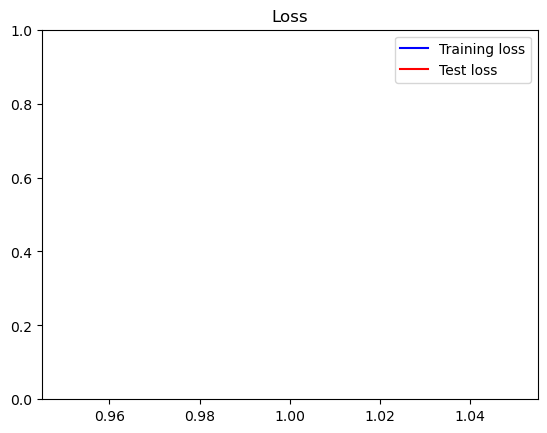

[0.21137044015023693]


In [6]:
import matplotlib.pyplot as plt
epochs = range(1, epoch_repeat + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.ylim(0, 1)
plt.title('Loss')
plt.legend()
plt.show()

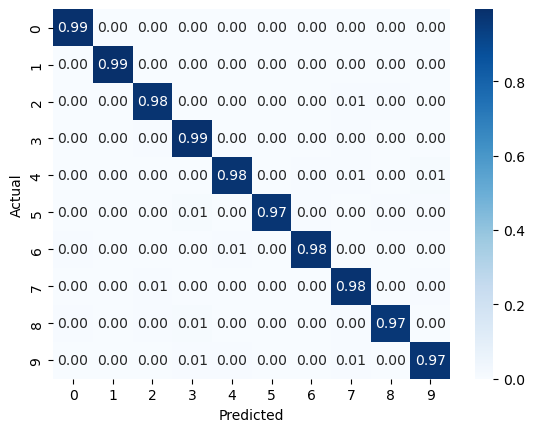

In [160]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = nn.predict(test_set.images.reshape(10000, -1))
y_true = test_set.labels.reshape(10000, -1)

y_pred_decoded = np.argmax(y_pred, axis=1)
y_true_decoded = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_decoded, y_pred_decoded)

row_sums = cm.sum(axis=1, keepdims=True)
norm_cm = cm / row_sums

sns.heatmap(norm_cm, cmap="Blues", annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

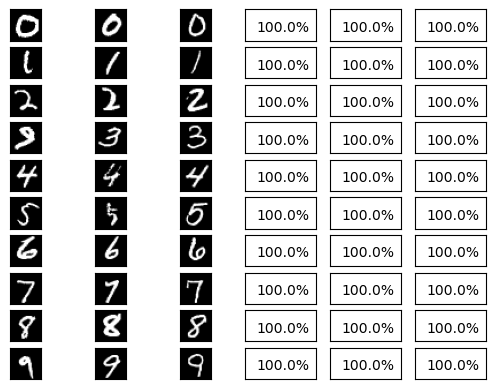

In [161]:
sorted_indices = np.argsort(y_pred, axis=0)[::-1]

for num in range(10):
    for counter in range(3):
        plt.subplot(10, 6, 6 * num + counter + 1)
        plt.imshow(test_set.images[sorted_indices[counter][num]][0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(10, 6, 6 * num + counter + 4)
        plt.xticks([])
        plt.yticks([])
        plt.text(0.15, 0.3, f"{np.max(y_pred[sorted_indices[counter][num]], axis=0) * 100}%")
plt.show()